## Bias-Variance for Ridge Regression

In [1]:
version$version.string ##R would be used in this question

[1] "R version 3.4.3 (2017-11-30)"

### Step I:
I.	Load Task2B_train.csv and Task2B_test.csv sets.

In [2]:
# reading the data
read_data <- function(fname, sc) {
    #read data 
  data <- read.csv(file=fname,head=TRUE,sep=",")
  nr = dim(data)[1]
  nc = dim(data)[2]
  #extract x
  x = data[1:nr,1:(nc-1)]
  #extract y
  y = data[1:nr,nc]
  if (isTRUE(sc)) {
    #scale x
    x = scale(x)
    #scale y
    y = scale(y)
  }
  return (list("x" = x, "y" = y))
}

In [4]:
train<- read_data("Task2B_train.csv", TRUE)
test<- read_data("Task2B_test.csv", TRUE)

### Step II:
II.	Sample 50 sets from the provided training set, each of which having 100 randomly selected data points (with replacement).

In [17]:
D = 100  # the number of samples in each selected dataset
L = 50 # number of datasets 

#number of points prepared for gengerating random samples
N<-length(train)

#number of rows in test and train datset
test.N<-nrow(test$x)
train.N<-nrow(train$x)

#set lambda
lambda<-seq(0,7,0.2)

#build a datafrmae
y_df<-data.frame(matrix(0,nrow=L*length(lambda), ncol=test.N+2))
#give first 2 colmns a name
names(y_df) <- c('lambda', 'l',  paste('y',1:(test.N), sep=''))
#lambda column
y_df$lambda<-rep(lambda, 1, each=L)
#column for counting number of dataset 
y_df$l<-rep(1:L, length(lambda), each=1)

#### Building sgd model

In [18]:
#sgd model
predict_func <- function(Phi, w){
  return(Phi%*%w)
} 

# auxiliary function to calculate the objective function for the training
train_obj_func <- function (Phi, w, label, lambda){
  # the L2 regulariser is already included in the objective function for training 
  return(mean((predict_func(Phi, w) - label)^2) + .5 * lambda * w %*% w)
}

# auxiliary function to compute the error of the model
get_errors <- function(train_data, test_data, W) {
  n_weights = dim(W)[1]
  errors = matrix(0,nrow=n_weights, ncol=2)
  for (tau in 1:n_weights) {
    errors[tau,1] = train_obj_func(train_data$x, W[tau,],train_data$y, 0)
    errors[tau,2] = train_obj_func(test_data$x, W[tau,],test_data$y, 0)
  }
  return(errors)
}


sgd_train <- function(train_x, train_y, lambda, eta, epsilon, max_epoch) {
  
  train_len = dim(train_x)[1]
  tau_max = max_epoch * train_len
  
  W <- matrix(0,nrow=tau_max, ncol=ncol(train_x)) 
  W[1,] <- runif(ncol(train_x))
  
  tau = 1 # counter 
  obj_func_val <-matrix(0,nrow=tau_max, ncol=1) 
  obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)
  
  while (tau <= tau_max){
    
    # check termination criteria
    if (obj_func_val[tau,1]<=epsilon) {break}
    
    # shuffle data:
    train_index <- sample(1:train_len, train_len, replace = FALSE)
    
    # loop over each datapoint
    for (i in train_index) {
      
      # increment the counter
      tau <- tau + 1
      if (tau > tau_max) {break}
      
      # make the weight update
      y_pred <- predict_func(train_x[i,], W[tau-1,])
      W[tau,] <- sgd_update_weight(W[tau-1,], train_x[i,], train_y[i], y_pred, lambda, eta)
      
      # keep track of the objective funtion
      obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)
    }
  }
  # resulting values for the training objective function as well as the weights
  return(list('vals'=obj_func_val,'W'=W))
}

# updating the weight vector
sgd_update_weight <- function(W_prev, x, y_true, y_pred, lambda, eta) {
  #loss func with L2 REG
  grad = - (c(y_true)-c(y_pred)) * x 
  return(W_prev - eta * (grad+lambda*W_prev))
}

### Step III:

In [19]:
eta=0.01 #learning rate
epsilon=0.001 #a threshold on the cost (to terminate the process)
max_epoch=20 #maxium iterations

#for each dataset
for (l in 1:L){
    #randomly gengerte some index for training
    indx<-sample(train.N, D, replace = TRUE)
    for (lam in lambda){
         #train by sdg method and get last weight
        train_res <- sgd_train(train$x[indx,], c(train$y[indx]), lam, eta, epsilon, max_epoch)
        #sdg prediction
        predict <- test$x %*% train_res$W[nrow(train_res$W),]
        #write prediction into each row
        y_df[y_df$lambda==lam & y_df$l==l, -c(1,2)] <- predict
    }
}

In [20]:
#make a matrix to store all of lambda values
match <- matrix(lambda,nrow=length(lambda))
#collapse lambda and calculate each column mean
y_df.bar <- aggregate(y_df, list(y_df$lambda), mean)
#remove first 3 columns
y_df.bar <- as.matrix(y_df.bar[,-c(1:3)])

In [21]:
#calculate errors
error <- matrix(0,nrow=length(lambda))
#calculate bias
bias2 <- matrix(0,nrow=length(lambda))
#calculate variance
variance <- matrix(0,nrow=length(lambda))

#calculate bias^2, variance and test errors
for (idx in 1:nrow(match)){
  bias2[idx] <- mean((y_df.bar[idx,] - test$x)^2)
  variance[idx] <- mean((y_df[y_df$lambda==match[idx],-c(1,2)]-y_df.bar[idx,])^2)
  error[idx] <- mean((y_df[y_df$lambda==match[idx],-c(1,2)]-test$x)^2)
  
}

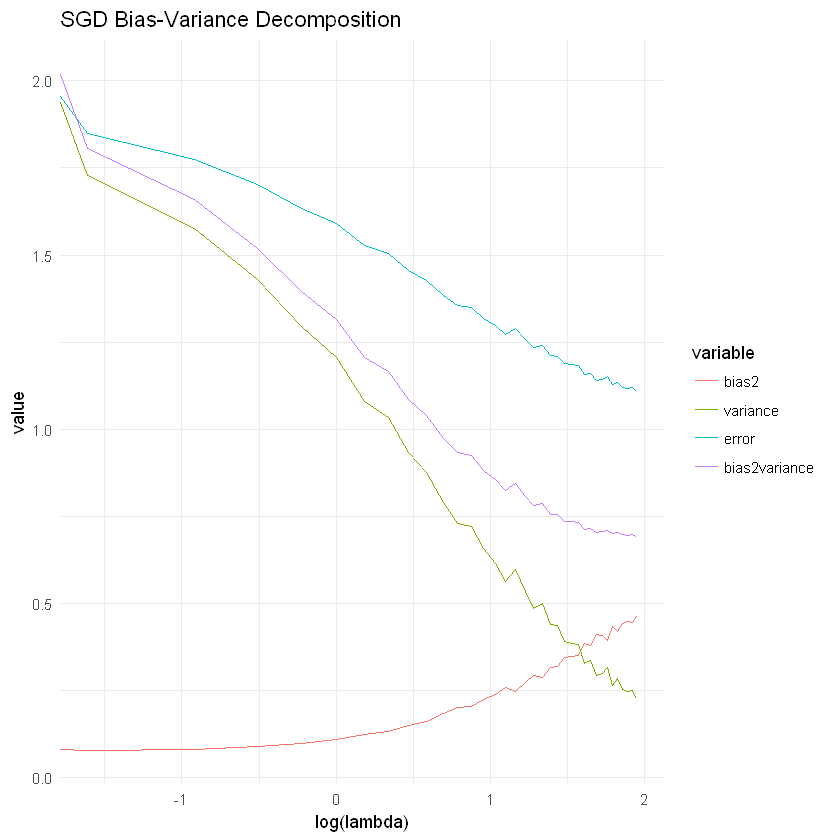

In [22]:
#plot these values.
library(ggplot2)
library(reshape2)
dat <- as.data.frame(cbind(lambda, bias2=bias2, variance, error, bias2+variance))
names(dat) <- c('lambda', 'bias2', 'variance', 'error', 'bias2variance')
dat.m <- melt(dat, id='lambda')
ggplot(data=dat.m, aes(x=log(lambda), y=value, color=variable)) + geom_line() + 
  labs(title='SGD Bias-Variance Decomposition') +  theme_minimal()

### Summary
Lambda=4.7 should be the best value of lambda. Because at that point, bias and variance are tradeoff. Which mean at this point, we can find a balance between bias and variance that minimizes the total error and get accurate model. 

From graph, we can see as the lambda increases, the bias slowly increases and the variance decreases. This points to the tradeoff between bias and variance due to model complexity, i.e. models that are too complex tend to have high variance and low bias, while models that are too simple will tend to have high bias and low variance. The best model will have both low bias and low variance. 

In this case, we repeat the model building process (through resampling) to obtain the average of prediction values. As the lambda increasing, bias becomes higher because these average prediction values are substantially different that the true value. Variance measures how inconsistent are the predictions from one another, over different training sets. And due to large variance, the most important factor that influence the tendency of error should be variance. So what we need to do is simultaneously reduce bias and variance as much as possible. There is a tradeoff (lambda=4.7) to be made when selecting models of different flexibility or complexity as well as to minimize these sources of error.
